---


Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. Name it *'LastName_FirstName_T2.1.ipynb'*. <ins>This is the master notebook so you will not be able to save your changes without copying it !</ins> Once you click on that, make sure you are working on that version of the notebook so that your work is saved.



---

### In this Colab, we will explore the *TensorFlow Lite Converter* to create a TFLite model from the original TensorFlow model.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


We import the following libraries -

1.   [tensorflow](https://www.tensorflow.org/) - open source library to develop and train ML models
2.   [numpy](https://numpy.org/) - scientific computing in Python
3.   [keras](https://keras.io/) - deep learning framework built on top of TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# 1. Define TensorFlow Model

We consider a single-layer neural network for a Linear Regression Task - modeling Y = 2X + 3. We define the optimizer to be 'Stochastic Gradient Descent' and the loss function to be 'Mean Squared Error'.

In [ ]:
my_layer = Dense(units=1, input_shape=[1])
model = Sequential([my_layer])

OPT = 'sgd'# < YOUR CODE HERE >
LOSS = 'mean_squared_error'# < YOUR LOSS HERE >
model.compile(optimizer=OPT, loss=LOSS)

xs = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([1.0, 3.0, 5.0, 7.0, 9.0, 11.0], dtype=float)

***Hint:*** Use optimizer='sgd', loss='mean_squared_error'

### Train Model

We fit our neural network on the defined data (Xs and Ys).

In [ ]:
hist = model.fit(xs, ys, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 445ms/step - loss: 113.6811
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 89.7314
Epoch 3/200
1/1 [==============================] - 0s 9ms/step - loss: 70.8829
Epoch 4/200
1/1 [==============================] - 0s 7ms/step - loss: 56.0480
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 44.3708
Epoch 6/200
1/1 [==============================] - 0s 9ms/step - loss: 35.1781
Epoch 7/200
1/1 [==============================] - 0s 8ms/step - loss: 27.9402
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 22.2404
Epoch 9/200
1/1 [==============================] - 0s 13ms/step - loss: 17.7507
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 14.2132
Epoch 11/200
1/1 [==============================] - 0s 8ms/step - loss: 11.4250
Epoch 12/200
1/1 [==============================] - 0s 7ms/step - loss: 9.2265
Epoch 13/200
1/1 [===========================

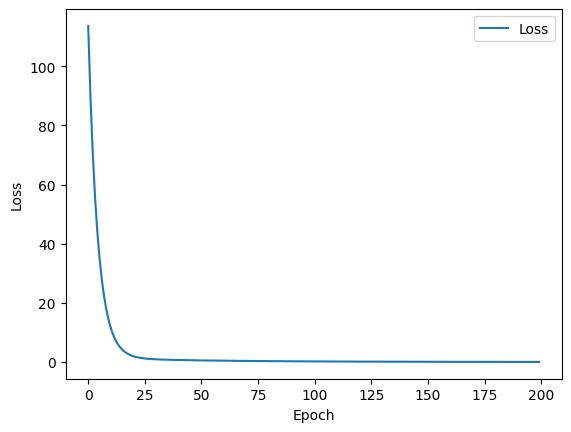

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(hist.history['loss'], label='Loss')

# Set the title and labels
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the plot
plt.legend()
plt.show()

### Predict X = 10.0 and inspect learned weights

We evaluate our trained model by tasking it to predict the output (Y) for input (X) = 10.0! We further observe the model parameters (weight and bias)

In [ ]:
print(model.predict([10.0]))

print("Here are the parameters that the model learned: {}".format(my_layer.get_weights()))

1/1 [==============================] - 0s 84ms/step
[[23.455902]]
Here are the parameters that the model learned: [array([[2.0660758]], dtype=float32), array([2.7951431], dtype=float32)]


### Save Model

We save our trained model to a specified path. This is done using the `saved_model.save()` API that exports a TensorFlow model object to SavedModel format. You can read more about the API [here](https://www.tensorflow.org/api_docs/python/tf/saved_model).

The saved model (.pb file) can be found on the left tab under Files/.  

In [ ]:
export_dir = 'saved_TF_model/model1'
tf.saved_model.save(model, export_dir)

# 2. Convert TF Model to TFLite Model

We use the `tf.lite.TFLiteConverter.from_saved_model()` API to load the saved TF model and then use the `convert()` method to transform into the TFLite model. You can read more about the API [here](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter).

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)     # instantiating the converter object
tflite_model = converter.convert()                                   # converting TF model to TF Lite model

### Storing TFLite model onto disk

We import the following:

1. [pathlib](https://docs.python.org/3/library/pathlib.html) - Object-oriented filesystem paths

We write the TFLite model (model.tflite) to the disk - this file encapsulates the model and its saved weights. This is the compressed model that we deploy on edge devices!

\

We first create the desired path using the `pathlib.Path()` API. We then write the contents from our converted tflite model to this path using the `tflite_model_file.write_bytes()` API. You can read more about this API [here.](https://www.tensorflow.org/lite/performance/post_training_quant)



In [ ]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')

In [ ]:
print("Size of TensorFlow Lite Model in bytes:", tflite_model_file.write_bytes(tflite_model)  )   #output = no. of bytes of model

Size of TensorFlow Lite Model in bytes: 1092


The `tflite_model_file.write_bytes()` API also returns the size of the model in bytes. The *model.tflite* file can be found on the left tab under File/


---


**Question 1**: Why do we convert our TensorFlow model to a TensorFlow Lite model for edge devices?

**Answer:** Because the size is too big and we need to make it smaller and therefore faster among other advantages like energy efficiency and so on.

---

### Model Inference using TensorFlow Interpreter

Now that we have a TFLite model, how do we test it out without actually needing an edge device?

We don't need a RPi, smartphone, or an embedded system! TensorFlow Lite provides an interface called **Interpreter** that allows us to load the TF Lite model and run inference in Python. You can read more about the TFLite Interpreter [here](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter).

We use the `tf.lite.Interpreter()` API to load the tflite model to the Interpreter and we extract the input and output tensor details to run inference. The input and output details help us define important details such as the shape of our input for inference and expected output after inference. It also defines the index of the interpreter assigned for the input and output tensors.  

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors - to run inference
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

[{'name': 'serving_default_dense_1_input:0', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 3, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


We then format our value to be predicted (10.0) as a tensor according to how the model accepts input, run inference, and read the result on the output tensor and store it in a variable (here, tflite_results).

In [ ]:
to_predict = np.array([[10.0]], dtype=np.float32)   # based on 'shape' value in input details
print("value to predict:", to_predict)

# setting the 'to_predict' value at the appropriate index location of input tensor
interpreter.set_tensor(input_details[0]['index'], to_predict)

# running inference on 'to_predict' value
interpreter.invoke()

#read the result that is stored at the appropriate index location of output tensor
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print("predicted value:", tflite_results)

value to predict: [[10.]]
predicted value: [[23.455902]]



---


**Question 2**: List any two reasons why we require the model input and output tensor details.

**Answer:** It's important for pre-processing and post-processing of the data. This way, we can also ensure compatibility when deploying.

---

### Use the interepreter to predict X = 5.5

In the code cell below, use the already instantiated 'Interpreter' to predict X = 5.5!

In [ ]:
# TODO
to_predict = np.array([[5.5]], dtype=np.float32)   # based on 'shape' value in input details
print("value to predict:", to_predict)

# setting the 'to_predict' value at the appropriate index location of input tensor
interpreter.set_tensor(input_details[0]['index'], to_predict)

# running inference on 'to_predict' value
interpreter.invoke()

#read the result that is stored at the appropriate index location of output tensor
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print("predicted value:", tflite_results)


value to predict: [[5.5]]
predicted value: [[14.15856]]
